# Plate Reader Data Analysis

In our search for a mutant of *$\beta$-galactosidase* that is most efficient for hydrolysis of a phenol ester of galactose (and so perhaps effective at catalyzing the reverse esterification) we have perfromed a series of enzyme kinetics runs using a plate reader. The general methodology is described in the document that accompanies this notebook.

## The Multiwell Plates

We have 13 plates that were used. The contents of each well are documented in the plate plan files. These diles are found in the `plateplan` folder and are named as `plateXX.csv`. Examone the contents of the folder to see the scheme for naming the files. Examine the contents of a file to familarize yourself with the format.

In each plan the 12 columns each contain a given concentration of an enzyme and each row contains a given concentration of substrate. That gives us 96 sets of absorbance vs time data for each plate. 

## The Data

The data for each well in each plate is store in the `data` folder. Examine this folder. You will see 1248 data files representing 8 substrat concentrations in 156 enzyme kinetics experiments. Some of these data are blanks but 

In [1]:
### Read in experimental parameters from plate plan file
### Create lists of column & row names, enzyme names, enzyme & substrate conc 
### Convert units to standard units (molar and min^-1)
### Calculate e_405 for nitrophenol at given pH

import pandas as pd
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT
import numpy as np

file_location = "data1/plateplans/"
file_name = "Plate01.csv"
pH = 7.0

df, plate, e_NPA = BT.read_plate_setup(file_location+file_name, pH)

print(plate.keys())
df


dict_keys(['row_name_list', 'S_conc_list', 'lane_name_list', 'E_conc_list', 'E_Name_list'])


,Column,Enzyme,E_Conc,Row,S_Conc
0,1,Blank,0.0,A,0.005
1,2,wt1,0.5,B,0.010
2,3,BL_oaO,0.5,C,0.020
3,4,BL_z1n,0.5,D,0.040
4,5,BL_CrO,0.5,E,0.080
5,6,BL_FWY,0.5,F,0.160
6,7,BL_GZQ,0.5,G,0.320
7,8,BL_ZXr,0.5,H,0.500
8,9,BL_n5l,0.5,NaN,NaN
9,10,BL_4JL,0.5,NaN,NaN


In [4]:
### Contact sheet. Ticks deleted on plots inside the set.
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

BT.contact_sheet("data1/data/Plate01", 
                 columns = plate["lane_name_list"],
                 rows = plate["row_name_list"],
                 enzymes = plate["E_Name_list"],
                 fancy = True)

Plot saved as plots/plot_contact_sheet_01.pdf


,Column,Row,slope,slope stderr,int,int stderr,RSQ
0,6,B,0.006024,0.000329,-0.001035,0.00066,0.957265


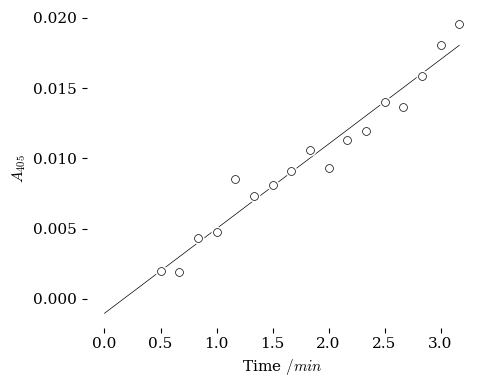

Plot saved as data1/data/plate01.pdf
Data saved as data1/data/plate01.csv


In [15]:
### Plot initial rates for a well or a set of wells

#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

### get plate info from plate plan file
df, plate, e_NPA = BT.read_plate_setup("data1/setup/Plate01_setup.csv", pH = 7.0)

### Chose columns to plot
#Column_list = ["1","2","3"]
Column_list = ["6"]
#Column_list = ["4", "5", "6"]
#Column_list = plate["lane_name_list"]

### Chose rows within the columns
#Row_list = ["A","B","C"]
Row_list = ["B"]
#Row_list = plate["row_name_list"]

plate_name_list = ["plate01"]

for plate_name in plate_name_list:
    data_file_root_name = "data1/data/" + plate_name
    result = BT.plot_lanes(data_file_root_name, 
                           Column_list, Row_list, 
                           Fraction_time_span = .05, 
                           Line_Fit = True,
                           Display_Plot = True,
                           Display_Data = True,
                           fancy = True,
                           tiny_points = False,
                           tiny_line = False
                           )

slope = 0.0308 +/- 0.000423


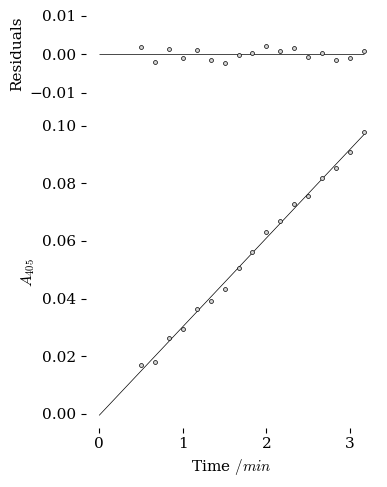

Plot saved as plots/Plate00_Cell_w_residuals_4_F.pdf


In [1]:
### Analysis of a single cell with slope and differentials

import pandas as pd
#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT
import numpy as np

data_name = "data1/data/plate00"
BT.plot_w_residuals(data_name, "4", "F", 
                      Fraction_time_span = 0.05,
                      plot_file = "plots/Plate00_Cell_w_residuals",
                      fancy = True)

slope = 0.00541 +/- 5.07e-05
slope = 0.00642 +/- 0.000357


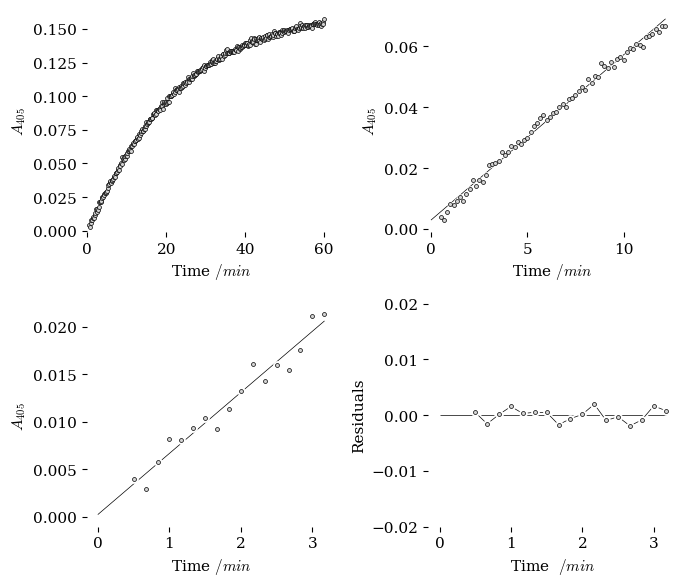

Plot saved as plot1/Cell_w_residuals_7_C.pdf


()

In [3]:
### Analysis of a single cell with slope and differentials

#!wget https://raw.githubusercontent.com/blinkletter/StealThisCode/main/BiochemToolbox.py
#!pip install uncertainties  # to install 'Uncertainties' package in Colab. 
import BiochemToolbox as BT

lane_name = "7"
row_name = "C"
data_name = "data1/data"

BT.plot_four_w_residuals(data_name, lane_name, row_name, 
                         Fraction_time_span_medium = 0.2,
                         Fraction_time_span_short = 0.05,
                         plot_file = "plot1/Cell_w_residuals",
                         fancy=True)